In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import joblib
import random
from tqdm import tqdm
import cv2
import numpy as np

In [2]:
DATA_DIR = 'E:/assignment'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_set/training_set')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test_set/test_set')

In [3]:
Categories = []

for i in os.listdir(TRAIN_DATA_DIR):
    Categories.append(i)
    
print(Categories)

['cats', 'dogs']


In [10]:
img_size=64
train_data=[]
for c in Categories:
    path=os.path.join(TRAIN_DATA_DIR, c)
    class_num=Categories.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_arr=cv2.imread(os.path.join(path,img))
            img_resized=cv2.resize(img_arr,(img_size,img_size))
            train_data.append([img_resized,class_num])
        except Exception as e:
            pass

print(len(train_data))

100%|██████████| 4006/4006 [00:33<00:00, 121.29it/s]

8005


In [11]:
img_size=64
test_data=[]
for c in Categories:
    path=os.path.join(TEST_DATA_DIR, c)
    class_num=Categories.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_arr=cv2.imread(os.path.join(path,img))
            img_resized=cv2.resize(img_arr,(img_size,img_size))
            test_data.append([img_resized,class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 1013/1013 [00:07<00:00, 144.25it/s]

2023


In [12]:
random.shuffle(train_data)
random.shuffle(test_data)

In [13]:
X_train = []
Y_train = []
for img,label in train_data:
    X_train.append (img)
    Y_train.append (label)

X_train = np.array(X_train).astype('float32').reshape (-1,64,64,3)
Y_train = np.array (Y_train)

print (X_train.shape, Y_train.shape)

(8005, 64, 64, 3) (8005,)


In [14]:
X_test = []
Y_test = []
for img,label in test_data:
    X_test.append (img)
    Y_test.append (label)

X_test = np.array(X_test).astype('float32').reshape (-1,64,64,3)
Y_test = np.array (Y_test)

print (X_test.shape, Y_test.shape)

(2023, 64, 64, 3) (2023,)


In [16]:
mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[100.148766 112.23469  123.40031 ]


In [17]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

for i in range(len(X_train)):
    for c in range(3):
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]

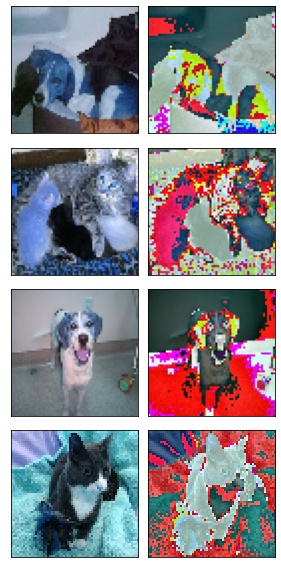

In [18]:
import matplotlib.pyplot as plt
c = 0
plt.figure(figsize=(4,8))
for i in range(4):
    plt.subplot(4,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [19]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train_norm.shape[1:]),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    
    
    
    layers.Flatten(),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8

In [20]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [22]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

h = model.fit(x=X_train_norm, y=Y_train, 
              epochs=2, 
              validation_split=0.2,
              batch_size=64,
              callbacks=[cb]
             )

Epoch 1/2
101/101 [==============================] - 42s 407ms/step - loss: 8.7632 - accuracy: 0.5114 - val_loss: 0.7134 - val_accuracy: 0.5609
Epoch 2/2
101/101 [==============================] - 41s 403ms/step - loss: 0.7478 - accuracy: 0.5493 - val_loss: 0.6539 - val_accuracy: 0.6002


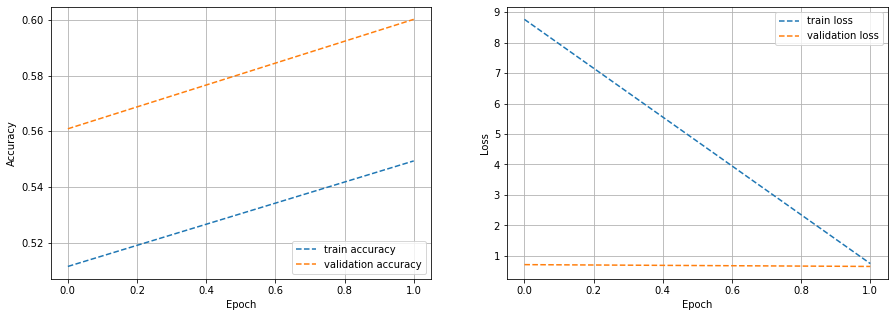

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '--', label='train accuracy')
plt.plot(h.history['val_accuracy'], '--', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '--', label='train loss')
plt.plot(h.history['val_loss'], '--', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()